# Test Holopy For Chlamys

# Importations & Load Data

## Importations

In [1]:
import numpy as np
import imageio

In [2]:
import os 
import sys
import copy
from tqdm import tqdm

In [3]:
sys.path

['/opt/anaconda3/envs/holopy/lib/python39.zip',
 '/opt/anaconda3/envs/holopy/lib/python3.9',
 '/opt/anaconda3/envs/holopy/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda3/envs/holopy/lib/python3.9/site-packages']

In [4]:
os.environ["OMP_NUM_THREADS"] = "1"

# os.environ.setdefault("OMPI_MCA_opal_cuda_support","true")
os.environ["OMPI_MCA_opal_cuda_support"] = "true" 

In [5]:
# Holopy
import holopy as hp
# Utilities
from holopy.core.io import load_average
from holopy.core.process import bg_correct, subimage, normalize, center_find
# Define Scatterers
from holopy.scattering import Sphere, Spheres, Cylinder
from holopy.scattering.scatterer import Spheroid
from holopy.scattering.scatterer import Capsule
# Theories
from holopy.scattering import Mie
from holopy.scattering.theory import Tmatrix, DDA
# Compute holograms and fit
from holopy.scattering import calc_holo
from holopy.inference import CmaStrategy
from holopy.inference import prior, ExactModel, NmpfitStrategy

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=200)
rc('savefig', dpi=600)

In [7]:
import platform
print(platform.architecture())

('64bit', 'ELF')


## Load Data

In [8]:
# Load an experimental video 
# vid_path = '/home/n.fares/DOCTORAT/analysis_chlamys/stage_elorri/data/20240702/2/Basler_acA1920-155um__22392621__20240702_152120657_trimmed_from_7250_s_to_8750_s.mp4'
# vid = imageio.get_reader(vid_path)

# Auxiliary Functions

In [9]:
# Adapted from pylorenzmie

def aziavgstd(data, center):
    '''Azimuthal average and standard deviation of data about center
    
    Parameters
    ----------
    data : array_like
        image data
    center : tuple
        (x_p, y_p) center of azimuthal average

    Returns
    -------
    avg : array_like
        One-dimensional azimuthal average of data about center
    std : array_like
        Standard deviation from the mean
    '''
    x_p, y_p = center
    ny, nx, _ = data.shape
    x = np.arange(nx) - x_p
    y = np.arange(ny) - y_p
    
    d = data.ravel()
    r = np.hypot.outer(y, x).astype(int).ravel()
    nr = np.bincount(r)
    avg = np.bincount(r, d) / nr
    std = np.sqrt(np.bincount(r, (d - avg[r])**2) / nr)
    rad = np.arange(len(avg))
    return rad, avg, std

# ADDA

In [10]:
# Choose a method 
# Either 'seq', 'mpi', or 'ocl'
method = 'mpi'

# Not coded yet, factice choice

In [11]:
# Remove adda methods already in path

# sys.path controls paths for python
# os.environ['PATH'] controls machine paths (.bashrc file)

# Get all the paths in a list
paths = os.environ['PATH'].split(':') 
# Loop over the elements but knowing that the list paths will change
for i, path in enumerate(os.environ['PATH'].split(':')): 
    if 'adda' in path: 
        paths.remove(path)
# Recombine the paths
os.environ['PATH'] = ":".join(paths)

# while 'adda' in os.environ["PATH"]:
#     os.environ['PATH'] = ":".join(os.environ["PATH"].split(":")[:-1])

print(os.environ['PATH'])

/opt/anaconda3/envs/holopy/bin:/opt/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/anaconda3/bin:/opt/pylon/bin:/usr/local/cuda-12.9/bin:/snap/bin


In [12]:
# Add adda to path
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'seq'])
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'mpi'])
os.environ['PATH'] += ''.join([':/home/n.fares/adda/src/', 'ocl'])

In [13]:
print(os.environ["PATH"])

/opt/anaconda3/envs/holopy/bin:/opt/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/anaconda3/bin:/opt/pylon/bin:/usr/local/cuda-12.9/bin:/snap/bin:/home/n.fares/adda/src/seq:/home/n.fares/adda/src/mpi:/home/n.fares/adda/src/ocl


# Compute Objects

In [14]:
# Some global variables

illum_polarization = (1, 0)

## Cylinder

### Tmatrix

In [15]:
%%time

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 300 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

theory = Tmatrix()

c = Cylinder(center=(h//2*spacing, h//4*spacing, 7), n = 1.59, d=0.5, h=1, rotation=(0., np.pi/2, 2*np.pi/3))

holo = calc_holo(
    detector, c, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)

CPU times: user 4.25 s, sys: 19.3 ms, total: 4.27 s
Wall time: 4.26 s


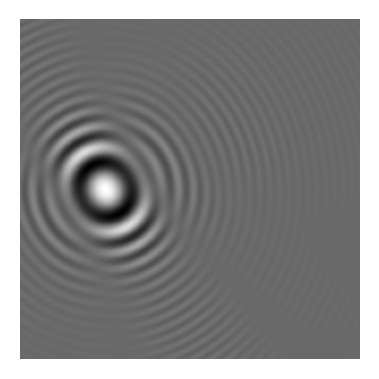

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))

ax.imshow(holo, cmap='gray')

ax.axis('off')

plt.tight_layout()
plt.show()

## Spherocylinder

### Compute an image with DDA

In [17]:
%%time

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 300 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

from holopy.scattering.theory.dda import DDA

theory = DDA(n_cpu=1, use_gpu=True)

scatterer = Capsule(center=(h//2*spacing, h//2*spacing, 15), n = 1.40, d=0.2, h=1, rotation=(np.pi/4, np.pi/4, 0.))

holo = calc_holo(
    detector, 
    scatterer, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory, 
)

CPU times: user 654 ms, sys: 296 ms, total: 950 ms
Wall time: 1.33 s


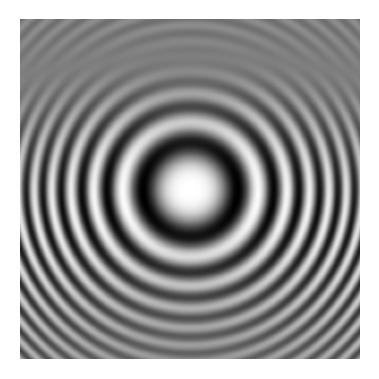

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))

ax.imshow(holo, cmap='gray')

ax.axis('off')

plt.tight_layout()
plt.show()

# Fit Theoretical Images

### Fit an image, with DDA or not

In [19]:
# Choose a hologram 

In [20]:
hc = 300
xc, yc = hc//2, hc//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

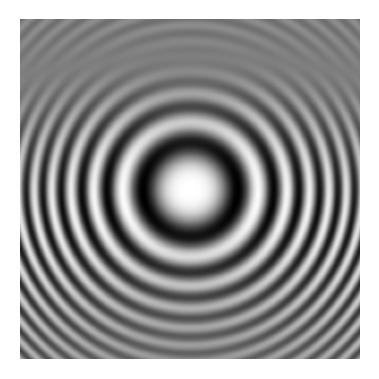

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))

ax.imshow(holo_c, cmap='gray')

ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
# Parameters you want to fit are defined as prior guesses 
x_p = hc//2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = hc//2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
h_p = 1 #prior.Uniform(4.1, 4.3, 4.2)
d_p = 0.2 #prior.Uniform(0, 0.5, 0.2)
n_p = 1.40 #prior.Uniform(1.39, 1.41, 1.40)
theta1 = np.pi / 4
theta2 = np.pi / 4
theta3 = 0.

# Define the scatterer
par_scatterer = Capsule(center=(x_p, y_p, z_p), n=n_p, d=d_p, h=h_p, rotation=(theta1, theta2, theta3))

In [23]:
%%time 

# Basic fit

# Define the theory
theory = DDA(use_gpu=True) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(0.5 * hc ** 2)
fit_strategy.ftol = 1e-8
fit_strategy.xtol = 1e-8
fit_strategy.gtol = 1e-8

# Fit 
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

print(fit_result.parameters)

{'center.2': 14.83676059379505}
CPU times: user 28.2 s, sys: 19.6 s, total: 47.8 s
Wall time: 56.9 s


In [25]:
model.illum_wavelen

0.532

In [26]:
%%time 

# CMA fit

# Define the theory
theory = DDA(use_gpu=False) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    ) 
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = CmaStrategy(popsize=50)
fit_strategy.npixels = int(0.5 * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit 
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

print(fit_result.parameters)

{'center.2': 15.000845215050738}
CPU times: user 212 ms, sys: 192 ms, total: 404 ms
Wall time: 14.9 s


In [27]:
holo_f = fit_result.hologram

{'center.2': 15.000845215050738}


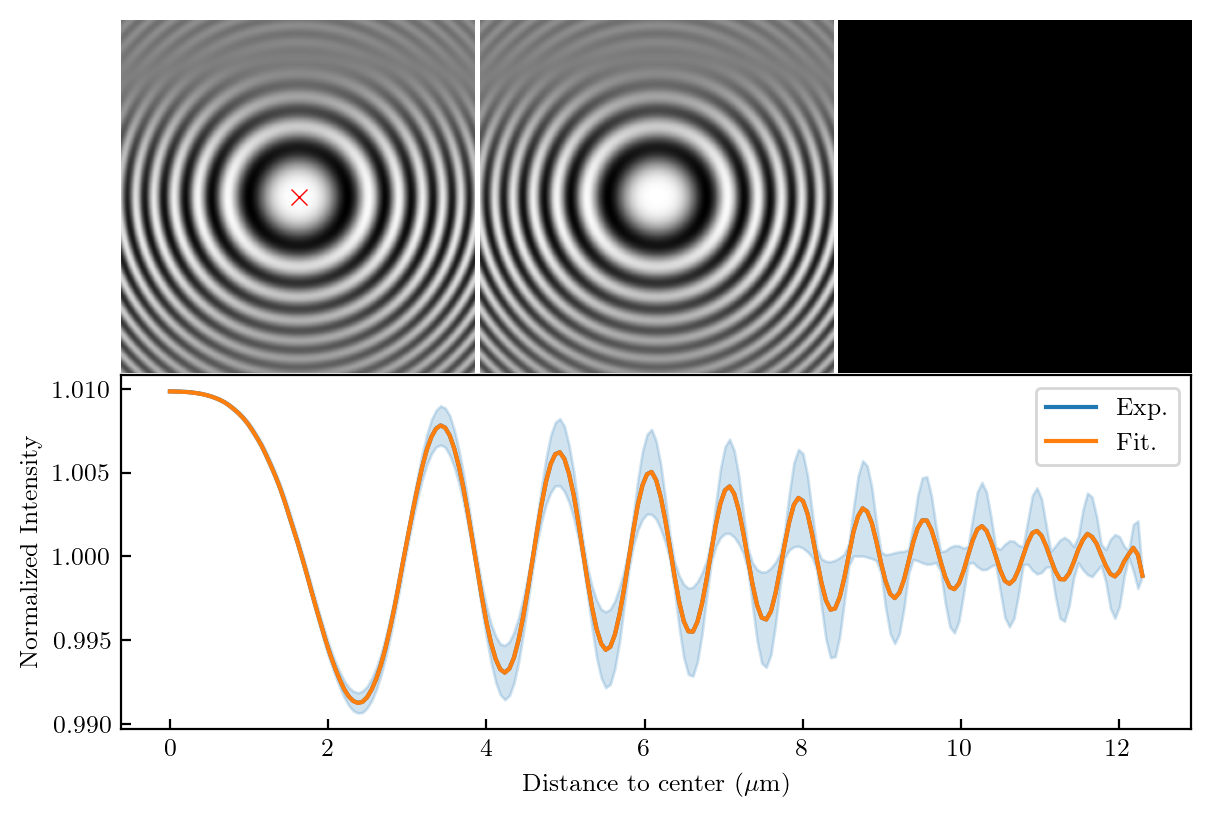

In [28]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [29]:
%%time 

# Parameters you want to fit are defined as prior guesses 
x_p = hc//2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = hc//2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
h_p = prior.Uniform(0.5, 1.5, 0.9)
d_p = prior.Uniform(0, 0.5, 0.2)
n_p = prior.Uniform(1.39, 1.41, 1.40)
theta1 = np.pi / 4
theta2 = np.pi / 4
theta3 = 0.

# Define the scatterer
par_scatterer = Capsule(center=(x_p, y_p, z_p), n=n_p, d=d_p, h=h_p, rotation=(theta1, theta2, theta3))

# CMA fit

# Define the theory
theory = DDA(use_gpu=False) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = CmaStrategy(popsize=50)
fit_strategy.npixels = int(0.5 * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit 
# fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 

# print(fit_result.parameters)


# Commented because leads to CalledProcessError

CPU times: user 1.56 ms, sys: 7.46 ms, total: 9.02 ms
Wall time: 11.9 ms


In [30]:
# holo_f = fit_result.hologram

In [31]:
# print(fit_result.parameters)

# fig = plt.figure(figsize=(15/2.54,10/2.54))
# nlin, ncol = 2, 3

# # Plot images
# ax1 = fig.add_subplot(nlin, ncol, 1)
# ax2 = fig.add_subplot(nlin, ncol, 2)
# ax3 = fig.add_subplot(nlin, ncol, 3)
# ax1.imshow(holo_c.data, cmap='gray')
# ax2.imshow(holo_f, cmap='gray')
# ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
# for ax in [ax1, ax2, ax3]:
#     ax.axis('off')

# # Compute radial intensity profiles 
# expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
# theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
# expe_rad = expe_rad * spacing 
# theo_rad = theo_rad * spacing 

# ax1.plot(hc//2, hc//2, marker='x', mec='r')

# # Plot radial intensity profile
# ax4 = fig.add_subplot(nlin, ncol, (4,6))
# ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
# ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
# ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
# ax4.legend()
# ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
# plt.tight_layout(pad=0.2)
# plt.show()

## Spheroid

In [32]:
%%time

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 200 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

a_p = 1
da_p = - 0.5
n_p = 1.4

theory = Tmatrix() #DDA(n_cpu=1, use_gpu=False)

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(h//2*spacing, h//2*spacing, 15), rotation=(2, 2, np.pi/4))

holo = calc_holo(
    detector, spheroid, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)

CPU times: user 2.31 s, sys: 8.31 ms, total: 2.32 s
Wall time: 2.31 s


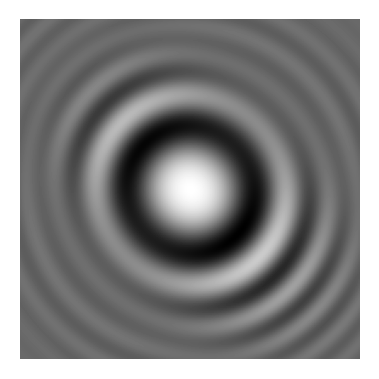

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54,5/2.54))

ax.imshow(holo, cmap='gray')

ax.axis('off')

plt.tight_layout()
plt.show()

In [34]:
hc = 200
xc, yc = hc//2, hc//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

In [35]:
# /!\ WARNING: Below for guesses, h must be modified to hc /!\

In [36]:
%%time 

# Fitting ``by hand'', CMA-es fit strategy

# Parameters you want to fit are defined as prior guesses 
x_p = h/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = h/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
a_p = prior.Uniform(0.5, 1.5, 1.2)
da_p = prior.Uniform(-1, 1, -0.3)
n_p = prior.Uniform(1.37, 1.43, 1.39)
theta1 = 2
theta2 = 2
theta3 = np.pi/4

# Define the scatterer
par_scatterer = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

# Define the theory
theory = DDA(n_cpu=1) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = CmaStrategy(popsize=50, parallel=10)
fit_strategy.npixels = int(0.2 * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit 
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

print(fit_result.parameters)

{'n': 1.3998478528759415, 'r.0': 0.9890610025324107, 'r.1.1': -0.48514147610425323, 'center.2': 14.968115387569865}
CPU times: user 1.75 s, sys: 2.65 s, total: 4.4 s
Wall time: 7min 34s


In [37]:
holo_f = fit_result.hologram

{'n': 1.3998478528759415, 'r.0': 0.9890610025324107, 'r.1.1': -0.48514147610425323, 'center.2': 14.968115387569865}


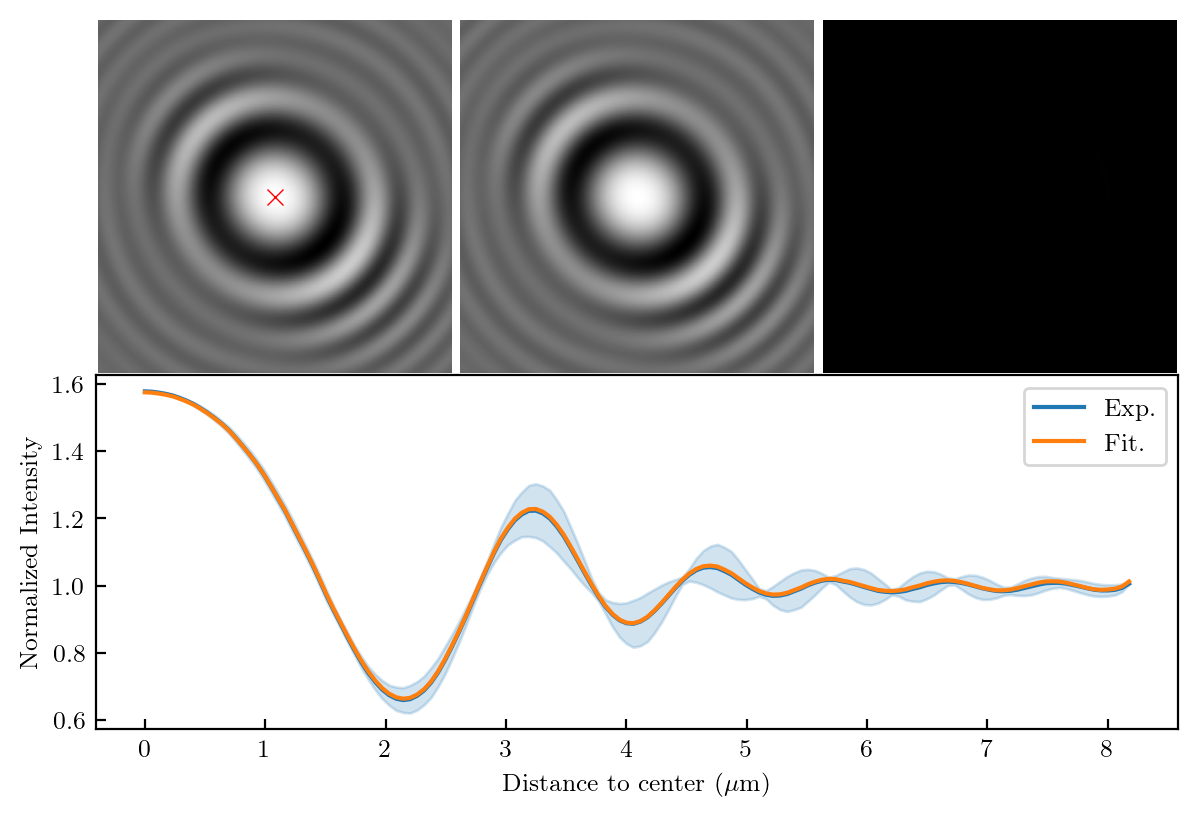

In [38]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [39]:
# %%time 

# Cell not run anymore, just here for souvenir

# Parameters you want to fit are defined as prior guesses 
x_p = h/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = h/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
a_p = prior.Uniform(0.5, 1.5, 1.2)
da_p = prior.Uniform(-1, 1, -0.3)
n_p = prior.Uniform(1.37, 1.43, 1.39)
theta1 = 2
theta2 = 2
theta3 = np.pi/4

# Define the scatterer
par_scatterer = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

# Define the theory
theory = DDA(use_gpu=True) #'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )

# Define the fit strategy
fit_strategy = CmaStrategy(popsize=50)
fit_strategy.npixels = int(0.2 * hc ** 2)
fit_strategy.resample_pixels = True
fit_strategy.parallel = 20 #'mpi'
fit_strategy.seed = 1000

# Fit 
# fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

# print(fit_result.parameters)


print('Running the fit gave:')
print("{'n': 1.3998478528759415, 'r.0': 0.9890610025324107, 'r.1.1': -0.48514147610425323, 'center.2': 14.968115387569865}")
print("CPU times: user 1.78 s, sys: 2.65 s, total: 4.43 s")
print("Wall time: 7min 54s")

Running the fit gave:
{'n': 1.3998478528759415, 'r.0': 0.9890610025324107, 'r.1.1': -0.48514147610425323, 'center.2': 14.968115387569865}
CPU times: user 1.78 s, sys: 2.65 s, total: 4.43 s
Wall time: 7min 54s


In [43]:
%%time

# Fitting ``by hand'', LM fit strategy

# It is faster, but innacurate for now.
# Innacuracy may explain why it is faster.

# Parameters you want to fit are defined as prior guesses 
x_p = hc/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=yc*spacing)
y_p = hc/2 * spacing #prior.Uniform(lower_bound=0, upper_bound=10, guess=xc*spacing)
z_p = prior.Uniform(lower_bound=14, upper_bound=16, guess=14.2)
a_p = prior.Uniform(0.5, 1.5, 1.2)
da_p = prior.Uniform(-1, 1, -0.3)
n_p = prior.Uniform(1.37, 1.43, 1.39)
theta1 = 2
theta2 = 2
theta3 = np.pi/4

# Define the scatterer
par_scatterer = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

# Define the theory
theory = 'auto' #DDA(n_cpu=1, use_gpu=False)

# Define the model 
model = ExactModel(
    scatterer=par_scatterer, calc_func=calc_holo, 
    noise_sd=None, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory,
    constraints=[], 
    )
# noise_sd can be set to None if all the prior variables are Uniform(). 
# Otherwise noise_sd must be set to something...
# ExactModel does not include alpha 
# If you want alpha: AlphaModel()

# model._parameter_names = ['r', 'x', 'y', 'z']

# Define the fit strategy
fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(0.6 * hc** 2)
# fit_strategy.ftol = 1e-8
# fit_strategy.xtol = 1e-8
# fit_strategy.gtol = 1e-8

# Fit 
fit_result = hp.fit(holo_c, model=model, strategy=fit_strategy) 
# Parameters to fit are included in the model through the prior objects. 

print(fit_result.parameters)

{'n': 1.3999281074681387, 'r.0': 0.9981178646099154, 'r.1.1': -0.49880364671703614, 'center.2': 14.993553497285388}
CPU times: user 3min 13s, sys: 1.81 ms, total: 3min 13s
Wall time: 3min 13s


In [44]:
holo_f = fit_result.hologram

{'n': 1.3999281074681387, 'r.0': 0.9981178646099154, 'r.1.1': -0.49880364671703614, 'center.2': 14.993553497285388}


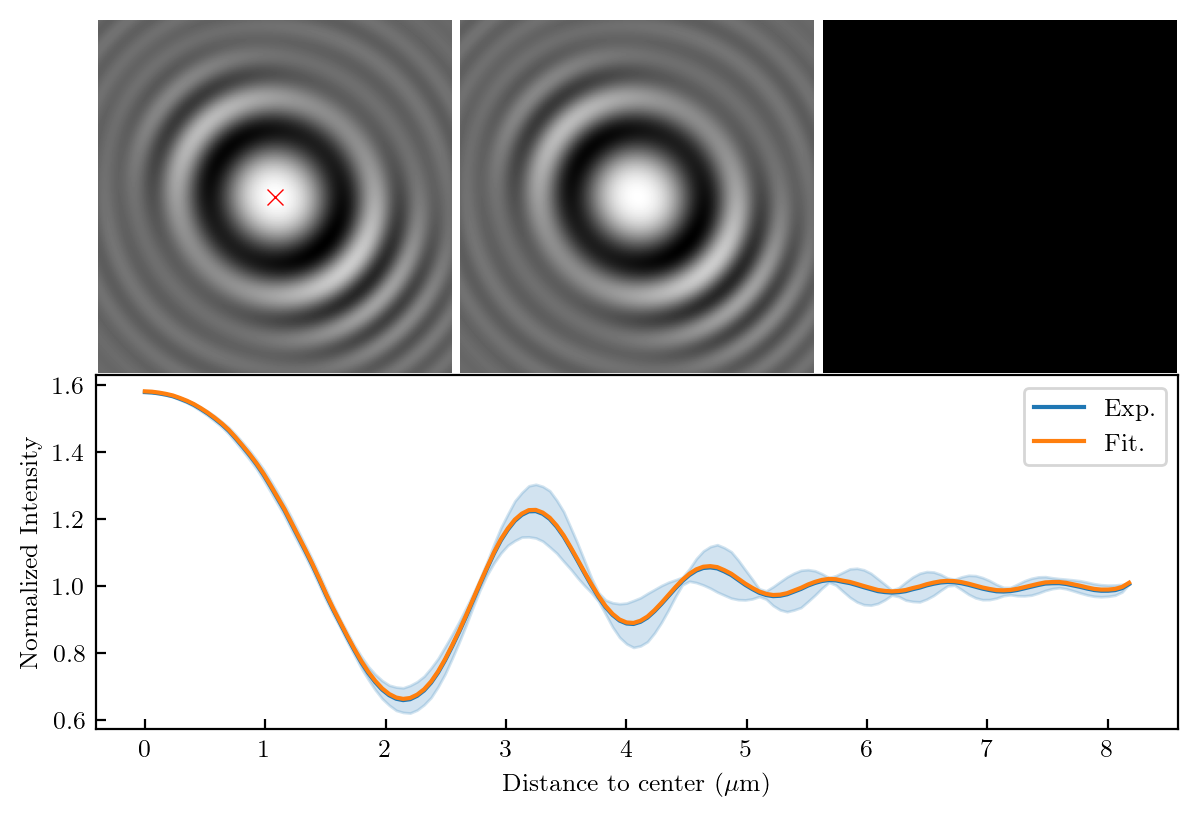

In [45]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [36]:
# hp.save('image_bis', holo_c)
# hp.save('image_bis_fitted', holo_f)

In [37]:
holo_c = hp.load('image_bis.h5')
holo_f = hp.load('image_bis_fitted.h5')

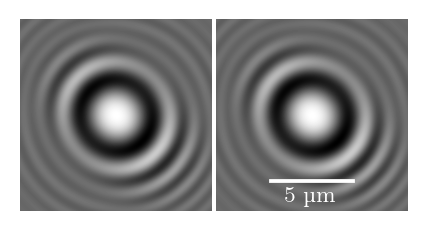

In [38]:
fig = plt.figure(figsize=(5/2.54,2.5/2.54))
nlin, ncol = 1, 2

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
# ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
# ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
# for ax in [ax1, ax2, ax3]:
for ax in [ax1, ax2]:
    ax.axis('off')

scalebar = AnchoredSizeBar(ax2.transData,
                           5/spacing, "5 µm", 'lower center', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fm.FontProperties(size=8)
                          )
ax2.add_artist(scalebar)

plt.tight_layout(pad=0.1)
plt.show()

In [39]:
# fig.savefig('fit_spheroid_a1_1um_a2_500nm_z_expected_15um_bis.pdf')

# Spheroid, Not by Hand

In [46]:
# Compute a Spheroid 

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 200 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

a_p = 1
da_p = - 0.5
n_p = 1.4

theta1 = 2
theta2 = 2
theta3 = np.pi / 4

theory = Tmatrix() #DDA(n_cpu=1, use_gpu=False)

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(h//2*spacing, h//2*spacing, 15), rotation=(theta1, theta2, theta3))

holo = calc_holo(
    detector, spheroid, 
    medium_index, illum_wavelen, illum_polarization, 
    theory=theory, 
)

In [47]:
# Crop 

hc = 200
xc, yc = h//2, h//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

In [48]:
guess_scatterer = Spheroid(n=1.39, r=(1.1, 0.8), center=(x_p, y_p, 14.2), rotation=(theta1+10/180*np.pi, theta2-10/180*np.pi, theta3+20/180*np.pi))

In [49]:


# Define the fitting strategy

percent_px = 0.3

fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(percent_px * hc ** 2)



In [50]:
# Which parameters 
parameters_to_fit = ['center', 'r', 'n', 'rotation']

In [51]:
%%time 

# Fit
fit_result = hp.fit(holo_c, guess_scatterer, strategy=fit_strategy, parameters=parameters_to_fit)

CPU times: user 2min 7s, sys: 8.96 ms, total: 2min 7s
Wall time: 2min 7s


In [52]:
holo_f = fit_result.hologram

{'n': 1.40091636369216, 'r.0': 1.001211843141062, 'r.1': 0.4996457367581464, 'rotation.0': 2.1278515153919404, 'rotation.1': 2.00401547918601, 'rotation.2': 0.7856893458396071, 'x': 5.799065303505654, 'y': 5.7989154892406285, 'z': 15.0171422728617, 'alpha': 0.9845849191509343}


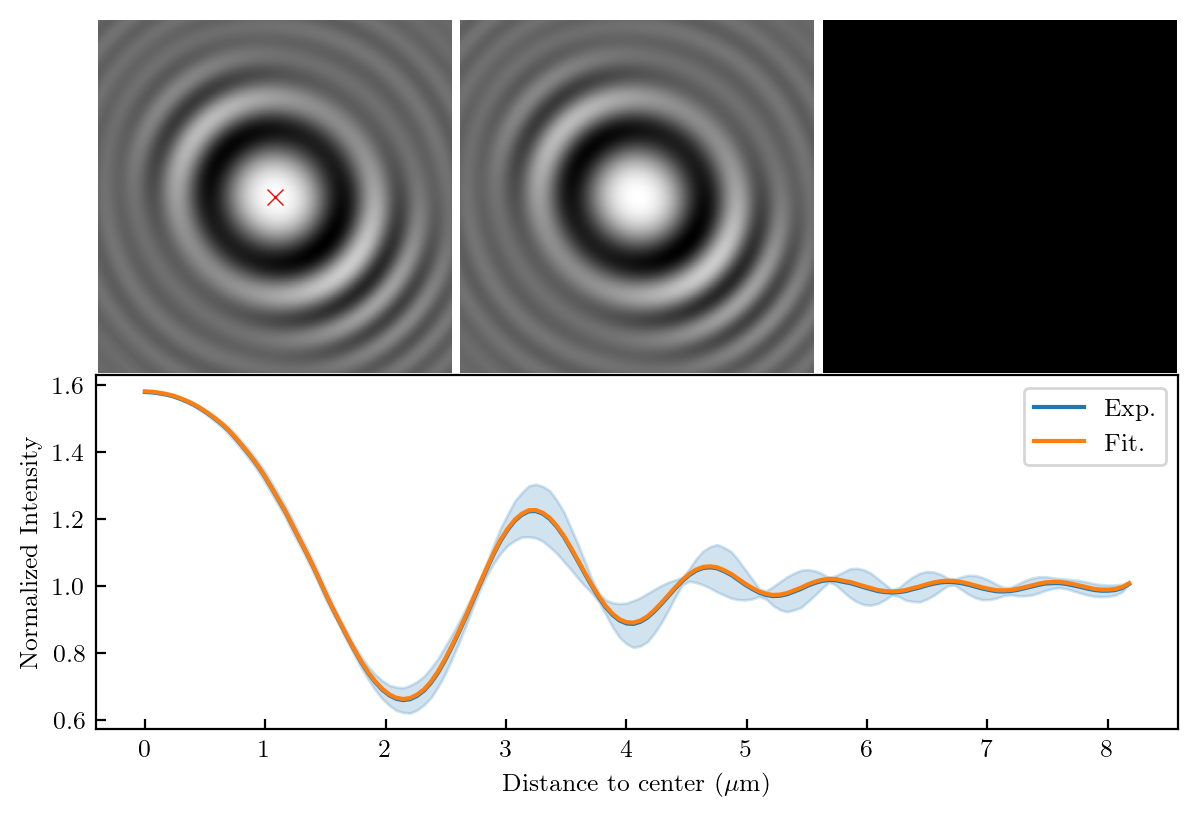

In [53]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [ ]:
# fig.savefig('fit_theoretical_spheroid_all.pdf')

# Test Compute Hologram

In [ ]:
# For know, I stopped at the computation of the Mueller matrix and S-matrix. 
# See holopy codes to propagate...

In [70]:
# %%time

# spacing = 0.05799
# medium_index = 1.33
# illum_wavelen = 0.532
# h = 200 # px

# detector = hp.detector_grid(shape=h, spacing=spacing)

# a_p = 1
# da_p = - 0.5
# n_p = 1.4

# theory = DDA(use_gpu=True) #DDA(n_cpu=1, use_gpu=False)

# spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(h//2*spacing, h//2*spacing, 15), rotation=(2, 2, np.pi/4))

# holo = calc_holo(
#     detector, spheroid, 
#     medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
#     theory=theory, 
# )

In [71]:
# holo.illum_wavelen

In [72]:
# %%time

# spacing = 0.05799
# medium_index = 1.33
# illum_wavelen = 0.532
# h = 200 # px

# detector = hp.detector_grid(shape=h, spacing=spacing)

# a_p = 1
# da_p = - 0.5
# n_p = 1.4

# theory = DDA(n_cpu=10, use_gpu=False)

# spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(h//2*spacing, h//2*spacing, 15), rotation=(2, 2, np.pi/4))

# holo = calc_holo(
#     detector, spheroid, 
#     medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
#     theory=theory, 
# )

In [73]:
# !adda_ocl -lambda 0.532 -m 1.4 0 -grid 30 -size 3.5 -shape ellipsoid 1 1.3 -orient 1 2 0 

# Fit Noisy Theoretical Images 

In [16]:
%%time

# Compute a Spheroid 

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 200 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

a_p = 1
da_p = - 0.2
n_p = 1.4

x_p = h//2*spacing
y_p = h//2*spacing
z_p = 15

theta1 = 5 * np.pi / 180
theta2 = 1
theta3 = 1

theory = Tmatrix() #DDA(n_cpu=1, use_gpu=False)

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

holo_ideal = calc_holo(
    detector=detector, scatterer=spheroid, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory, 
)

CPU times: user 3.24 s, sys: 15.6 ms, total: 3.26 s
Wall time: 3.24 s


In [55]:
# Noise the hologram 

noise = np.random.normal(loc=0.0, scale=np.std(holo_ideal.data)/2, size=np.shape(holo_ideal.data))

holo = copy.deepcopy(holo_ideal)
holo.data = holo_ideal + noise 

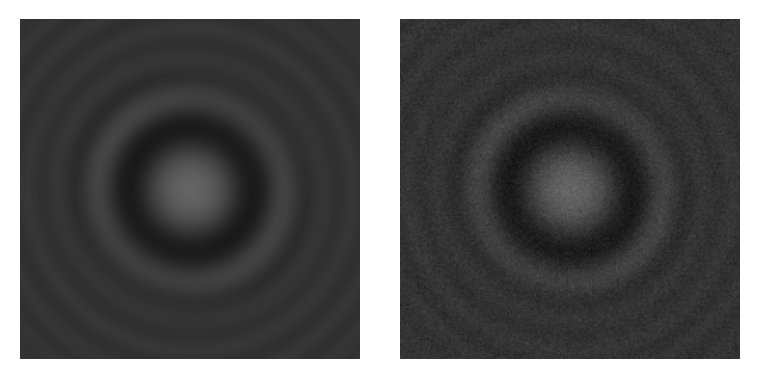

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))

vmin, vmax = 0, 5

axes[0].imshow(holo_ideal.data, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].imshow(holo.data, cmap='gray', vmin=vmin, vmax=vmax)

for i in range(len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [57]:
# Crop 

hc = 200
xc, yc = h//2, h//2

# holo_c = copy.deepcopy(holo)

# Crop
holo_c = subimage(holo, [h//2,h//2], hc)
# holo_c = copy.deepcopy(holo)
holo_c = normalize(holo_c)

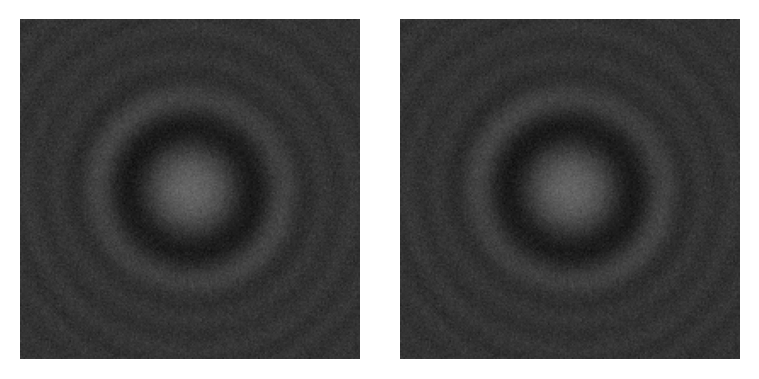

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))

vmin, vmax = 0, 5

axes[0].imshow(holo.data, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].imshow(holo_c.data, cmap='gray', vmin=vmin, vmax=vmax)

for i in range(len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [59]:
# Guess 

guess_scatterer = Spheroid(n=n_p-0.01, r=(a_p + 0.2, a_p + da_p - 0.1), center=(x_p, y_p, z_p), rotation=(theta1+3/180*np.pi, theta2-10/180*np.pi, theta3+1/180*np.pi))

In [60]:
# Define the fitting strategy

percent_px = 0.2

fit_strategy = NmpfitStrategy()
fit_strategy.npixels = int(percent_px * hc ** 2)

# fit_strategy = CmaStrategy(popsize=50, parallel=None)
# fit_strategy.npixels = int(percent_px * hc ** 2)
# fit_strategy.resample_pixels = True
# fit_strategy.parallel = 10 #'mpi'
# fit_strategy.seed = 1000

In [61]:
# Which parameters 
parameters_to_fit = ['center', 'r', 'n', 'rotation']

In [62]:
%%time 

# Fit
fit_result = hp.fit(holo_c, guess_scatterer, strategy=fit_strategy, parameters=parameters_to_fit)

CPU times: user 1min 31s, sys: 6.62 ms, total: 1min 31s
Wall time: 1min 31s


In [63]:
holo_f = fit_result.hologram

{'n': 1.3983636609012327, 'r.0': 1.0121073290996663, 'r.1': 0.8284921659235917, 'rotation.0': 0.13904669217241467, 'rotation.1': 1.1030149226758896, 'rotation.2': 0.9772929653113235, 'x': 5.792047005923365, 'y': 5.795590026071771, 'z': 15.040517806291573, 'alpha': 0.9673995877605122}


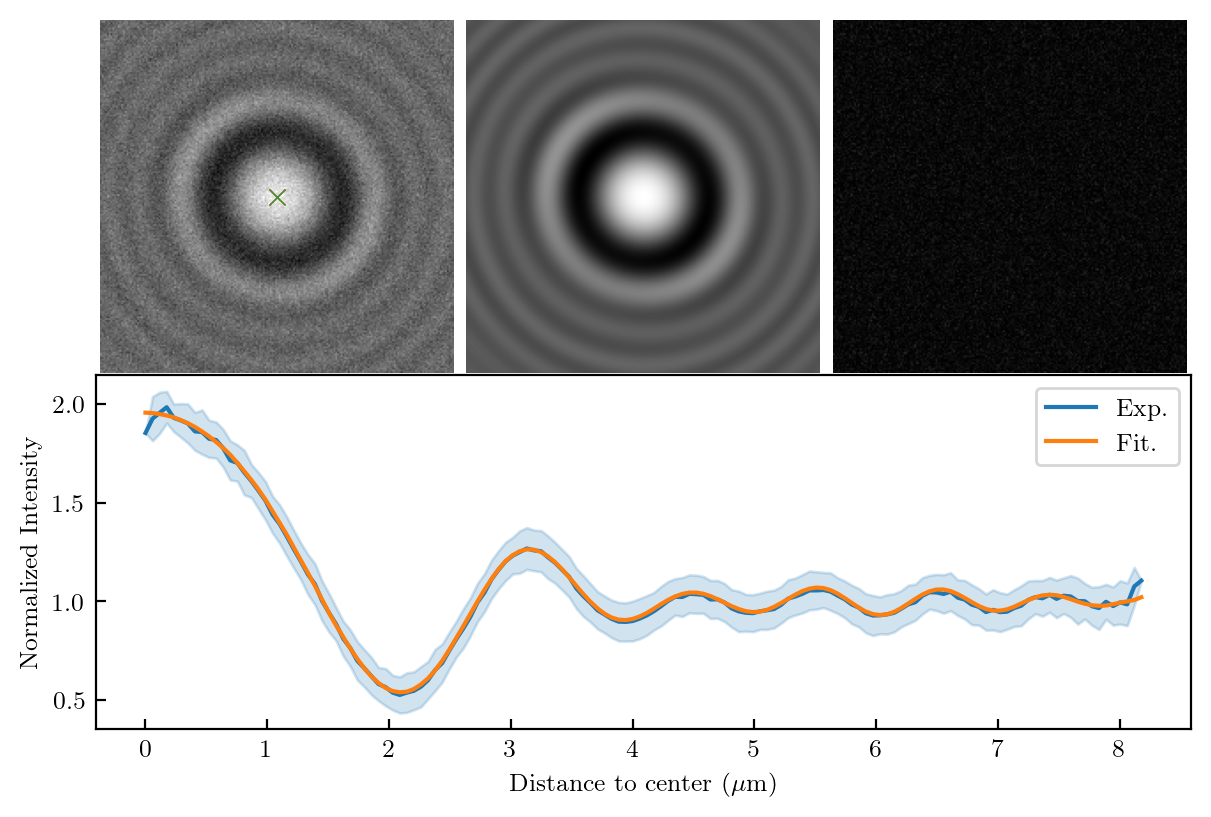

In [64]:
print(fit_result.parameters)

fig = plt.figure(figsize=(15/2.54,10/2.54))
nlin, ncol = 2, 3

# Plot images
ax1 = fig.add_subplot(nlin, ncol, 1)
ax2 = fig.add_subplot(nlin, ncol, 2)
ax3 = fig.add_subplot(nlin, ncol, 3)
ax1.imshow(holo_c.data, cmap='gray')
ax2.imshow(holo_f, cmap='gray')
ax3.imshow(np.abs(holo_c.data - holo_f.data), cmap='gray', vmin=0, vmax=2)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')

# Compute radial intensity profiles 
expe_rad, expe_avg, expe_std = aziavgstd(holo_c.data, [hc//2, hc//2]) 
theo_rad, theo_avg, _ = aziavgstd(holo_f.data, [hc//2, hc//2]) 
expe_rad = expe_rad * spacing 
theo_rad = theo_rad * spacing 

ax1.plot(hc//2, hc//2, marker='x', mec='r')
ax1.plot(fit_result.parameters['x'] / spacing, fit_result.parameters['y'] / spacing, 'x', mec='tab:green')

# Plot radial intensity profile
ax4 = fig.add_subplot(nlin, ncol, (4,6))
ax4.plot(expe_rad, expe_avg, ls='-', c='tab:blue', label='Exp.')
ax4.fill_between(expe_rad, expe_avg-expe_std, expe_avg+expe_std, color='tab:blue', alpha=0.2)
ax4.plot(theo_rad, theo_avg, ls='-', c='tab:orange', label='Fit.')
ax4.legend()
ax4.set(xlabel=r'Distance to center ($\mathrm{\mu m}$)', ylabel=r'Normalized Intensity')
plt.tight_layout(pad=0.2)
plt.show()

In [65]:
# fig.savefig('fit_all_parameters_spheroid_a1_1um_a2_0p5um_noisy_one_std.pdf')

In [66]:
print(theta1)
print(theta2)
print(theta3)

0.08726646259971647
1
1


In [67]:
fit_result.parameters

{'n': 1.3983636609012327,
 'r.0': 1.0121073290996663,
 'r.1': 0.8284921659235917,
 'rotation.0': 0.13904669217241467,
 'rotation.1': 1.1030149226758896,
 'rotation.2': 0.9772929653113235,
 'x': 5.792047005923365,
 'y': 5.795590026071771,
 'z': 15.040517806291573,
 'alpha': 0.9673995877605122}

In [33]:
0.05 * 180 / np.pi

2.864788975654116

In [17]:
theory = DDA(n_cpu=10, use_gpu=False)

spheroid = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

holo_ideal = calc_holo(
    detector=detector, scatterer=spheroid, 
    medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
    theory=theory, 
)

CalledProcessError: Command '['mpiexec', '-n', '10', 'adda_mpi', '-scat_matr', 'ampl', '-store_scat_grid', '-lambda', '0.4', '-save_geom', '-shape', 'read', '/tmp/tmpi6sfi7f7/tmptui3jmil', '-dpl', '10.526315789473683', '-m', '1.0526315789473684', '0.0']' returned non-zero exit status 139.

In [302]:
%%time

# Compute a Spheroid 

spacing = 0.05799
medium_index = 1.33
illum_wavelen = 0.532
h = 400 # px

detector = hp.detector_grid(shape=h, spacing=spacing)

a_p = 1
da_p = + 0.2
n_p = 1.4

x_p = h//2*spacing
y_p = h//2*spacing
z_p = 50

theta1 = 5 * np.pi / 180
theta2 = 1
theta3 = 1

theory = DDA(n_cpu=10, use_gpu=False)

scatterer = Spheroid(n=n_p, r=(a_p, a_p + da_p), center=(x_p, y_p, z_p), rotation=(theta1, theta2, theta3))

# holo_ideal = calc_holo(
#     detector=detector, scatterer=scatterer, 
#     medium_index=medium_index, illum_wavelen=illum_wavelen, illum_polarization=illum_polarization, 
#     theory=theory, 
# )

CPU times: user 0 ns, sys: 12 ms, total: 12 ms
Wall time: 17.6 ms


In [303]:
import subprocess

import holopy

In [304]:
cmd = ['mpiexec', '-n', '10', 'adda_mpi', '-scat_matr', 'ampl', '-store_scat_grid', '-lambda', '0.4', '-save_geom', '-shape', 'read', './temp/', '-dpl', '10.526315789473683', '-m', '1.0526315789473684', '0.0']

In [305]:
cmd_str = ' '.join(cmd)
print(cmd_str)

mpiexec -n 10 adda_mpi -scat_matr ampl -store_scat_grid -lambda 0.4 -save_geom -shape read ./temp/ -dpl 10.526315789473683 -m 1.0526315789473684 0.0


In [306]:
%%time 
result = subprocess.run(cmd, shell=True, capture_output=True, text=True) 

CPU times: user 1.23 ms, sys: 8.48 ms, total: 9.71 ms
Wall time: 20.1 ms


In [307]:
result

CompletedProcess(args=['mpiexec', '-n', '10', 'adda_mpi', '-scat_matr', 'ampl', '-store_scat_grid', '-lambda', '0.4', '-save_geom', '-shape', 'read', './temp/', '-dpl', '10.526315789473683', '-m', '1.0526315789473684', '0.0'], returncode=0, stdout='', stderr='--------------------------------------------------------------------------\nNo executable was specified on the prterun command line.\n\nAborting.\n--------------------------------------------------------------------------\n')

In [308]:
scatterer = holopy.scattering.interface.validate_scatterer(scatterer)

In [309]:
uschema = holopy.scattering.interface.prep_schema(detector, medium_index, illum_wavelen, illum_polarization)

In [310]:
scaling = 1

scaling = holopy.core.metadata.dict_to_array(detector, scaling)

print(scaling)

1


In [311]:
theory = holopy.scattering.interface.interpret_theory(scatterer, theory)

In [312]:
imageformer = holopy.scattering.imageformation.ImageFormation(theory)

In [313]:
# scattered_field = imageformer.calculate_scattered_field(scatterer, uschema)

In [314]:
from holopy.scattering.imageformation import ImageFormation

fieldcomputer = ImageFormation(theory)

# scattered_field = fieldcomputer._calculate_single_color_scattered_field(scatterer, uschema)

In [315]:
# field = fieldcomputer._get_field_from(scatterer, uschema)
# fieldcomputer._pack_field_into_xarray(field, uschema)

In [316]:
def _get_field_from(scatterer, schema):
        """
        Parameters
        ----------
        scatterer
        schema : xarray
            (it's always passed in as an xarray)

        Returns
        -------
        raveled fields, shape (npoints = nx*ny = schema.shape.prod(), 3)
        """
        wavevector = holopy.scattering.imageformation.get_wavevec_from(schema)
        positions = fieldcomputer._transform_to_desired_coordinates(
            schema, scatterer.center, wavevec=wavevector)
        scattered_field = np.transpose(
            fieldcomputer.scattering_theory.raw_fields(
                positions,
                scatterer,
                medium_wavevec=wavevector,
                medium_index=schema.medium_index,
                illum_polarization=schema.illum_polarization)
            )
        phase = np.exp(-1j * wavevector * scatterer.center[2])
        scattered_field *= phase
        return scattered_field

In [317]:
# field = _get_field_from(scatterer, uschema)
# fieldcomputer._pack_field_into_xarray(field, uschema)

In [318]:
wavevector = holopy.scattering.imageformation.get_wavevec_from(uschema)
positions = fieldcomputer._transform_to_desired_coordinates(uschema, scatterer.center, wavevec=wavevector)

In [319]:
# scattered_field = np.transpose(
#             fieldcomputer.scattering_theory.raw_fields(
#                 positions,
#                 scatterer,
#                 medium_wavevec=wavevector,
#                 medium_index=uschema.medium_index,
#                 illum_polarization=uschema.illum_polarization)
#             )
# phase = np.exp(-1j * wavevector * scatterer.center[2])
# scattered_field *= phase

In [320]:
fieldcomputer.scattering_theory

DDA(n_cpu=10, use_gpu=False, use_indicators=True, keep_raw_calculations=False, addacmd=[], suppress_C_output=True)

In [321]:
from holopy.scattering.theory.mie_f import mieangfuncs

In [322]:
# def raw_fields(pos, scatterer, medium_wavevec, medium_index, illum_polarization):
#     """Given a (3, N) array `pos`, etc, returns a (3, N) array"""
#     scat_matr = fieldcomputer.scattering_theory.raw_scat_matrs(
#         scatterer, pos, medium_wavevec=medium_wavevec,
#         medium_index=medium_index)

#     fields = np.zeros_like(pos.T, dtype=np.array(scat_matr).dtype)
#     for i, point in enumerate(pos.T):
#         kr, theta, phi = point
#         escat_sph = mieangfuncs.calc_scat_field(
#             kr, phi, scat_matr[i], illum_polarization.values[:2])
#         fields[i] = mieangfuncs.fieldstocart(escat_sph, theta, phi)
#     return fields.T

In [323]:
# scattered_field = raw_fields(
#     positions,
#     scatterer,
#     medium_wavevec=wavevector,
#     medium_index=uschema.medium_index,
#     illum_polarization=uschema.illum_polarization
# )

In [324]:
import tempfile

import glob

import shutil

import warnings

In [325]:
def _dpl(bounds, medium_wavelen, medium_index, n, max_dpl_size=None):
    # for objects much smaller than wavelength we should use
    # at least 10 dipoles per smallest dimension
    dpl = 10*medium_wavelen / min([np.abs(b[1]-b[0]) for b in bounds])
    # if the object has multiple domains, we need to pick the
    # largest required dipole number
    n = np.abs(n)
    if not np.isscalar(n):
        n = max(n)
    dpl = max(dpl, 10*(n/medium_index))
    # This allows you to fix a largest allowable dipole size (ie
    # so you can resolve features in an object)
    if max_dpl_size is not None:
        dpl = max(dpl, medium_wavelen / max_dpl_size)
    return dpl

def required_spacing(bounds, medium_wavelen, medium_index, n, max_dpl_size=None):
    return medium_wavelen / _dpl(bounds, medium_wavelen, medium_index, n, max_dpl_size=max_dpl_size)

In [326]:
def _adda_predefined(scatterer, medium_wavelen, medium_index, temp_dir):
    scatterer_pars = holopy.scattering.theory.dda._get_predefined_shape[scatterer.__class__](scatterer)
    cmd = []
    cmd.extend(['-eq_rad', str(scatterer_pars[0]), '-shape'])
    cmd.extend(scatterer_pars[1])
    cmd.extend(['-m', str(scatterer.n.real/medium_index),
                str(scatterer.n.imag/medium_index)])
    if hasattr(scatterer, 'rotation'):
        cmd.extend(['-orient'])
        cmd.extend([str(angle*180/np.pi) for angle in reversed(scatterer.rotation)])
        # rotation angles are gamma, beta, alpha in adda reference frame
    return cmd

def _adda_discretized(scatterer, medium_wavelen, medium_index, temp_dir, max_dpl_size=None):
    spacing = required_spacing(scatterer.bounds, medium_wavelen, medium_index, scatterer.n, max_dpl_size=max_dpl_size)
    outf = tempfile.NamedTemporaryFile(dir = temp_dir, delete=False)

    vox = scatterer.voxelate_domains(spacing)
    idx = np.concatenate([g[..., np.newaxis] for g in
                            np.mgrid[[slice(0,d) for d in vox.shape]]],
                            3).reshape((-1, 3))
    vox = vox.flatten()
    ns = holopy.core.utils.ensure_array(scatterer.n)
    n_domains = len(ns)
    if n_domains > 1:
        out = np.hstack((idx, vox[...,np.newaxis]))
        outf.write("Nmat={0}\n".format(n_domains).encode('utf-8'))
    else:
        out = idx
    np.savetxt(outf, out[np.nonzero(vox)], fmt='%d')
    outf.close()

    cmd = []
    cmd.extend(['-shape', 'read', outf.name])
    cmd.extend(
        ['-dpl', str(_dpl(scatterer.bounds, medium_wavelen, medium_index, scatterer.n, max_dpl_size=max_dpl_size))])
    cmd.extend(['-m'])
    for n in ns:
        m = n.real/medium_index
        if m == 1:
            warnings.warn("Adda cannot compute particles with index equal to medium index, adjusting particle index {} to {}".format(m, m+1e-6))
            m += 1e-6
        cmd.extend([str(m), str(n.imag/medium_index)])
    return cmd

In [327]:
def _run_adda(scatterer, medium_wavevec, medium_index, temp_dir, n_cpu, use_gpu, gpu_id=None, use_indicators=True, addacmd=[], suppress_C_output=True, max_dpl_size=None):
        medium_wavelen = 2*np.pi/medium_wavevec
        if use_gpu:
            cmd = ['adda_ocl']
            if gpu_id is not None:
                cmd.extend(['-gpu',str(gpu_id)])
        elif n_cpu == 1:
            cmd = ['adda']
        elif n_cpu > 1:
            cmd = ['mpiexec', '-n', str(n_cpu), 'adda_mpi']
        cmd.extend(['-scat_matr', 'ampl'])
        cmd.extend(['-store_scat_grid'])
        cmd.extend(['-lambda', str(medium_wavelen)])
        cmd.extend(['-save_geom'])
        cmd.extend(addacmd)

        predefined = isinstance(scatterer, tuple(holopy.scattering.theory.dda._get_predefined_shape.keys()))
        layered=isinstance(scatterer, Sphere) and not np.isscalar(scatterer.r)
        if not predefined or use_indicators or layered:
            scat_args = _adda_discretized(scatterer, medium_wavelen, medium_index, temp_dir, max_dpl_size=max_dpl_size)
        else:
            scat_args = _adda_predefined(scatterer, medium_wavelen, medium_index, temp_dir)
        cmd.extend(scat_args)

        # os.chdir(temp_dir)
        
        adda_out = subprocess.run(cmd, cwd=temp_dir, check=True,
                                  capture_output=suppress_C_output)

        # adda_out is a subprocess.CompletedProcess object that contains the
        # output of ADDA; could be used for diagnostics
        return adda_out

In [352]:
def raw_scat_matrs(
    scatterer, pos, medium_wavevec, medium_index, 
    n_cpu, use_gpu, gpu_id=None, use_indicators=True, 
    addacmd=[], suppress_C_output=True, 
    temp_dir='./', keep_raw_calculations=False, 
):
        angles = pos.T[:, 1:] * 180/np.pi
        # temp_dir = './' #tempfile.mkdtemp()

        outf = open(os.path.join(temp_dir, 'scat_params.dat'), 'wb')

        # write the header on the scattering angles file
        header = ["global_type=pairs", "N={0}".format(len(angles)), "pairs="]
        outf.write(('\n'.join(header)+'\n').encode('utf-8'))
        # Now write all the angles
        np.savetxt(outf, angles)
        outf.close()

        # os.chdir(temp_dir)

        _run_adda(
            scatterer, medium_wavevec=medium_wavevec,
            medium_index=medium_index, temp_dir=temp_dir, 
            n_cpu=n_cpu, use_gpu=use_gpu, 
            gpu_id=gpu_id, use_indicators=use_indicators, addacmd=addacmd, suppress_C_output=suppress_C_output)

        # Go into the results directory, there should only be one run
        result_dir = glob.glob(os.path.join(temp_dir, 'run000*'))[0]
        # if self.keep_raw_calculations:
        #     self._last_result_dir = result_dir

        adda_result = np.loadtxt(os.path.join(result_dir, 'ampl_scatgrid'),
                                 skiprows=1)
        # columns in result are
        # theta phi s1.r s1.i s2.r s2.i s3.r s3.i s4.r s4.i

        # Combine the real and imaginary components from the file into complex
        # numbers
        s = adda_result[:,2::2] + 1.0j*adda_result[:,3::2]

        # Now arrange them into a scattering matrix, see Bohren and Huffman p63
        # eq 3.12
        scat_matr = np.array([[s[:,1], s[:,2]], [s[:,3], s[:,0]]]).transpose()

        if keep_raw_calculations:
            print(("Raw calculations are in: {0}".format(temp_dir)))
        else:
            shutil.rmtree(temp_dir)
        # shutil.rmtree(temp_dir)

        return scat_matr

In [353]:
import time

In [354]:
def raw_fields(
    pos, scatterer, medium_wavevec, medium_index, illum_polarization, 
    n_cpu, use_gpu, gpu_id=None, 
    use_indicators=True, addacmd=[], suppress_C_output=True, 
    temp_dir = './', 
):
    """Given a (3, N) array `pos`, etc, returns a (3, N) array"""

    t0 = time.time()
    print(t0)
    
    scat_matr = raw_scat_matrs(
        scatterer, pos, medium_wavevec=medium_wavevec,
        medium_index=medium_index, 
        n_cpu=n_cpu, use_gpu=use_gpu,
        gpu_id=gpu_id, use_indicators=use_indicators, addacmd=addacmd, suppress_C_output=suppress_C_output, 
        temp_dir=temp_dir
    )

    print(time.time() - t0)

    fields = np.zeros_like(pos.T, dtype=np.array(scat_matr).dtype)
    for i, point in enumerate(pos.T):
        kr, theta, phi = point
        escat_sph = mieangfuncs.calc_scat_field(
            kr, phi, scat_matr[i], illum_polarization.values[:2])
        fields[i] = mieangfuncs.fieldstocart(escat_sph, theta, phi)
    return fields.T

In [355]:
# %%time

# _run_adda(
#     scatterer, medium_wavevec=wavevector,
#     medium_index=medium_index, temp_dir = './', #tempfile.mkdtemp(),
#     n_cpu=1, use_gpu=True, 
#     use_indicators=False, 
# )

In [397]:
temp_dir = tempfile.mkdtemp()

In [398]:
temp_dir

'/tmp/tmpkxmwg2kv'

In [399]:
write_scat_params(
    scatterer, positions, medium_wavevec=wavevector,
    medium_index=medium_index, 
    n_cpu=1, use_gpu=False,
    temp_dir=temp_dir, 
)

In [400]:
%%time 

scattered_field = raw_fields(
    positions,
    scatterer,
    medium_wavevec=wavevector,
    medium_index=uschema.medium_index,
    illum_polarization=uschema.illum_polarization, 
    n_cpu=10, 
    use_gpu=False, 
    temp_dir=temp_dir, 
)
scattered_field = np.transpose(scattered_field)

1749717003.936716


CalledProcessError: Command '['mpiexec', '-n', '10', 'adda_mpi', '-scat_matr', 'ampl', '-store_scat_grid', '-lambda', '0.4', '-save_geom', '-shape', 'read', '/tmp/tmpkxmwg2kv/tmpp2u19rfa', '-dpl', '10.526315789473683', '-m', '1.0526315789473684', '0.0']' returned non-zero exit status 139.

In [384]:
scattered_field

array([[ 0.01314286+1.15775342e-02j, -0.00058484-4.10864445e-04j,
         0.00291296+2.59022072e-03j],
       [ 0.01526639+8.69624538e-03j, -0.00065354-2.86501124e-04j,
         0.00339035+1.95105656e-03j],
       [ 0.01675764+5.44862533e-03j, -0.00069589-1.51861591e-04j,
         0.0037273 +1.22898958e-03j],
       ...,
       [ 0.01813151-9.17236475e-04j, -0.00073047+1.48083337e-05j,
        -0.00401786+2.08314945e-04j],
       [ 0.01794772+2.75660687e-03j, -0.00072302-1.29161322e-04j,
        -0.0039763 -6.06564759e-04j],
       [ 0.01701872+6.33322240e-03j, -0.00068693-2.70241360e-04j,
        -0.00376938-1.39933724e-03j]])

In [385]:
phase = np.exp(-1j * wavevector * scatterer.center[2])
scattered_field *= phase

In [386]:
_scattered_field = np.copy(scattered_field)

In [387]:
def _is_detector_view_point_or_flat(detector_view):
        detector_dims = detector_view.dims
        if 'flat' in detector_dims:
            point_or_flat = 'flat'
        elif 'point' in detector_dims:
            point_or_flat = 'point'
        else:
            msg = ("xarray `detector_view` is not in the form of a 1D list " +
                   "of coordinates. Call ``flat`` first.")
            raise ValueError(msg)
        return point_or_flat

In [388]:
# import xarray as xr

In [389]:
# def _pack_field_into_xarray(scattered_field, schema):
#         """Packs the numpy.ndarray, shape (N, 3) ``scattered_field`` into
#         an xr.DataArray, shape (N, 3). This function needs to pack the
#         fields [flat or point, vector], with the coordinates the
#         same as that of the schema.

#         For a flat schema, cartesian coordinates, the coordinates of the field
#         dataarray should be

#           * flat     (flat) MultiIndex
#           * x        (flat) float64
#           * y        (flat) float64
#           * z        (flat) float64 or int64 (if 0)
#           * vector   (vector) <U1 'x' 'y' 'z'so that 'flat' or 'point'

#         'flat' is a multi-index coordinate created by when the schema is
#         flattened. It indexes the 3D positions of the detector points. 'vector'
#         is a new dimensional coordinate that indexes the 3D components of the
#         field vector.
#         """
#         flattened_schema = holopy.core.metadata.flat(schema)  # now either point or flat
#         point_or_flat = _is_detector_view_point_or_flat(flattened_schema)
        
#         coords = {
#             point_or_flat: flattened_schema.coords[point_or_flat],
#             vector: ['x', 'y', 'z']}
#         scattered_field = xr.DataArray(
#             scattered_field, dims=[point_or_flat, vector], coords=coords,
#             attrs=schema.attrs)
#         return scattered_field

In [390]:
# scattered_field = _pack_field_into_xarray(scattered_field, uschema)

In [391]:
from holopy.scattering.imageformation import ImageFormation

imageformater = ImageFormation(theory)

In [392]:
scattered_field = imageformater._pack_field_into_xarray(_scattered_field, uschema)

In [393]:
reference_field = uschema.illum_polarization

In [394]:
holo = holopy.scattering.interface.scattered_field_to_hologram(scattered_field * scaling, reference_field)

In [395]:
holo = holopy.scattering.interface.finalize(uschema, holo)

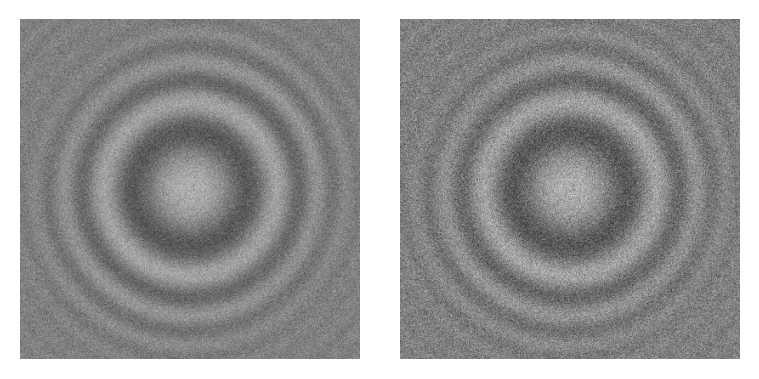

In [396]:
# Noise the hologram 

noise = np.random.normal(loc=0.0, scale=np.std(holo.data)/2, size=np.shape(holo.data))
holo.data = holo_ideal + noise 

fig, axes = plt.subplots(1, 2, figsize=(10/2.54, 5/2.54))

vmin, vmax = 0, 2

axes[0].imshow(holo.data, cmap='gray', vmin=vmin, vmax=vmax)
axes[1].imshow(holo.data + noise, cmap='gray', vmin=vmin, vmax=vmax)

for i in range(len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()